In [1]:
from typing import List
import seaborn as sns
import os

import nnts
import nnts.data
import nnts.experiments
from nnts import utils
import nnts.torch.preprocessing as preprocessing
import nnts.torch.trainers
import nnts.torch.models
import nnts.metrics
import nnts.torch.datasets
import nnts.loggers
import nnts.pandas
import nnts.trainers
import nnts.torch.utils
import covs 
import torch.nn.functional as F

sns.set()

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
data_path = "data"
model_name = "base-lstm"
dataset_name = "hospital"
results_path = "nb-results"
metadata_path = os.path.join(data_path, f"{model_name}-monash.json")
metadata = utils.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = utils.Hyperparams()

nnts.loggers.makedirs_if_not_exists(PATH)

In [3]:
params

Hyperparams(input_dim=1, hidden_dim=40, n_layers=2, dropout=0.1, output_dim=1, batch_size=128, lr=0.001, epochs=100, patience=10, rnn_type='lstm', early_stopper_patience=30, batches_per_epoch=200, weight_decay=1e-08, training_method=<TrainingMethod.TEACHER_FORCING: 1>, optimizer=None, scheduler=<Scheduler.ONE_CYCLE: 1>)

In [7]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )
## Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

scenario_list.append( 
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=3, skip=1
    )
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garethmd. Use `wandb login --relogin` to force relogin


BaseLSTM(
  (decoder): BaseLSTMDecoder(
    (rnn): LSTM(2, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Epoch 1 Train Loss: 149.5746307373047
Epoch 1 train loss: 149.5746307373047, valid loss: 20.862897872924805
Epoch 2 Train Loss: 38.09552001953125
Epoch 2 train loss: 38.09552001953125, valid loss: 22.999542236328125
Epoch 3 Train Loss: 31.499155044555664
Epoch 3 train loss: 31.499155044555664, valid loss: 21.596559524536133
Epoch 4 Train Loss: 27.973142623901367
Epoch 4 train loss: 27.973142623901367, valid loss: 19.644330978393555
Epoch 5 Train Loss: 24.655540466308594
Epoch 5 train loss: 24.655540466308594, valid loss: 21.359304428100586
Epoch 6 Train Loss: 25.593416213989258
Epoch 6 train loss: 25.593416213989258, valid loss: 20.231035232543945
Epoch 7 Train Loss: 22.8

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


abs_error,▁
abs_target_mean,▁
abs_target_sum,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mae,▁
mape,▁
mase,▁
mse,▁
nd,▁
rmse,▁
seasonal_error,▁


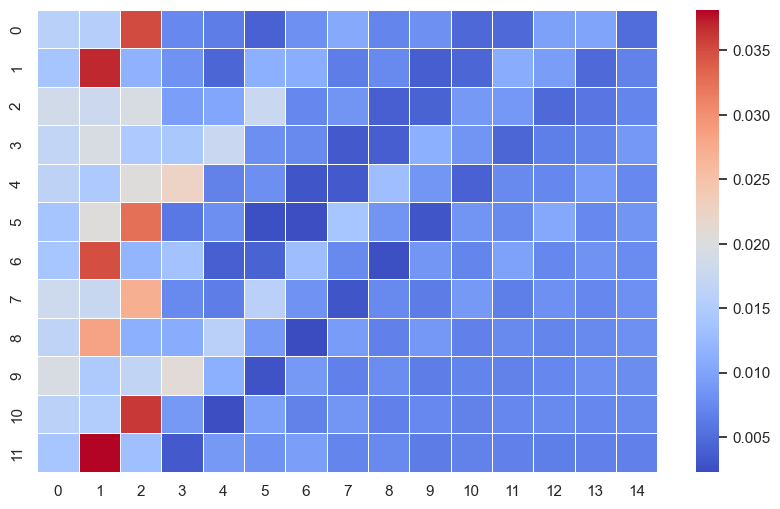

In [6]:
for scenario in scenario_list[:1]:
    nnts.torch.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    trn_dl, val_dl, test_dl = nnts.torch.utils.create_dataloaders(
        df,
        nnts.pandas.split_test_val_train_last_horizon,
        metadata.context_length,
        metadata.prediction_length,
        Dataset=nnts.torch.datasets.TimeseriesDataset,
        dataset_options={
            "context_length": metadata.context_length,
            "prediction_length": metadata.prediction_length,
            "conts": scenario.conts,
        },
        batch_size=params.batch_size,
    )

    net = nnts.torch.models.BaseLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
    )
    logger = nnts.loggers.WandbRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH
    )
    trner = nnts.torch.trainers.ValidationTorchEpochTrainer(
        nnts.trainers.TrainerState(),
        net,
        params,
        metadata,
        os.path.join(PATH, f"{scenario.name}.pt"),
        loss_fn=F.smooth_l1_loss,
    )
    logger.configure(trner.events)
    evaluator = trner.train(trn_dl, val_dl)
    handle = net.decoder.register_forward_hook(logger.log_activations)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length, hooks=handle
    )
    handle.remove()
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, nnts.metrics.calculate_seasonal_error(trn_dl, metadata)
    )
    logger.log(test_metrics)
    logger.finish()

In [ ]:
scenario = scenario_list[0]
import torch
import nnts.torch.trainers

In [ ]:
nnts.torch.datasets.seed_everything(scenario.seed)
df, scenario = covs.prepare(df_orig.copy(), scenario)
splitter = nnts.pandas.LastHorizonSplitter()
split_data = splitter(df, metadata.context_length, metadata.prediction_length)
_, _, test_dl = nnts.data.create_trn_val_test_dataloaders(
    split_data,
    metadata,
    scenario,
    params,
    nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
)
net = covs.model_factory(model_name, params, scenario, metadata)
best_state_dict = torch.load(f"{PATH}/{scenario.name}.pt")
net.load_state_dict(best_state_dict)

class ActivationVisualizer:
    def __init__(self):
        self.activations = []

    def hook_handler(self, module, input, output):
        input_0 = output[0][0]
        self.activations.append(input_0[:, -1].detach().cpu().numpy())

visualiser = ActivationVisualizer()
handle = net.decoder.register_forward_hook(visualiser.hook_handler)
net.eval()

In [ ]:
batch = next(iter(test_dl))

In [ ]:
with torch.no_grad():
    output = nnts.torch.models.trainers.validate(net, batch, scenario.prediction_length, metadata.context_length)

In [ ]:
handle.remove()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(visualiser.activations, cmap="coolwarm", linewidths=0.5)
plt.show()

In [ ]:
batch["X"][0, : metadata.context_length, ...].cpu().numpy(), batch["X"][
    0, - scenario.prediction_length:, ...
].cpu().numpy()

In [ ]:
output[0][0]

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(output[0][0], cmap="coolwarm", linewidths=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap([ v[-1:] for v in visualiser.activations], cmap="coolwarm", linewidths=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap([v[-2:] for v in visualiser.activations], cmap="coolwarm", linewidths=0.5)
plt.show()

In [ ]:
import nnts.pandas


csv_aggregator = nnts.pandas.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [ ]:
import nnts.experiments
import nnts.experiments.plotting


df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = nnts.experiments.plotting.plot(df_list, scenario.prediction_length)

In [ ]:
univariate_results = results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

In [ ]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [ ]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=["covariates", "error"])

In [ ]:
sorted(results["error"].unique().tolist())